This file is part of GaPSE
Copyright (C) 2022 Matteo Foglieni

GaPSE is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

GaPSE is distributed in the hope that it will be useful, but
WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU
General Public License for more details.

You should have received a copy of the GNU General Public License
along with GaPSE. If not, see <http://www.gnu.org/licenses/>.
```


```

# PS_L01234

Here we compute the Power Spectrum (PS) sum for the Galaxy Number Counts (GNC) General Relativistic (GR) effects, for the multipoles $L=0,1,2,3,4$.

The files are saved in the `PS_L01234/` directory. You can speed up the computation running the Julia scripts `PS_L01234_pt0.jl`, `PS_L01234_pt1.jl`, ..., `PS_L01234_pt4.jl` in different terminals.

All the output files will be placed in the directory `PS_L01234/` (check to have it, otherwise create it). There is also the script `PS_L01234.jl` that perform the same computations, but you can speed up them running the Julia scripts `PS_L01234_pt0.jl`, `PS_L01234_pt1.jl`, ..., `PS_L01234_pt4.jl` in different terminals.
The galaxy bias, magnification bias and evolution bias are respectively set to:

$$
    b = 1.5 \;,\quad s_{\mathrm{b}} = 0 \; , \quad \mathit{f}_{\mathrm{evo}} = 0
$$

They are defined as constants in the next cell; you can of course copy this notebook and create another one with different paramenters (remember to change also the `filenames_appendix = "_b1p5-sb0-fevo0`)

In [1]:
const B = 1.5;     # Galaxy bias
const S_B = 0.0;   # Magnification bias
const F_EVO = 0.0; # Evolution bias
const filenames_appendix = "_b1p5-sb0-fevo0";

In [2]:
COMPUTE_XIS_GNC = false; # set this to true if you want to compute the TPCFs of the GNC!

In [3]:
DIR = "PS_L01234/"; # Directory where the files will be saved
@assert isdir(DIR) "ERROR: DIR=$DIR DOESN'T EXIST!!!"

ps_kwargs(alg::Symbol = :fftlog) = alg == :twofast ?
    Dict(
        :alg => :twofast, :epl => true, :pr => false, 
        :N_left => 12, :N_right => 12,
        :p0_left => [-2.0, 1.0], :p0_right => [-2.0, 1.0],
        :int_s_min => 1e0, :int_s_max => 1200.0,
        :cut_first_n=>0, :cut_last_n => 0
    ) : alg == :fftlog ?
    Dict(
        :alg => :fftlog, :pr=>true, :ν => 1.5, 
        :n_extrap_low => 100, :n_extrap_high => 100, 
        :n_pad => 500, :cut_first_n=>50, :cut_last_n => 0,
    ) : throw(AssertionError("alg = :fftlog (recommended) or alg = :twofast !"));
tf = :fftlog;

The plane-parallel (or flat sky) approximation is a widely used approximation that allow to derive simple analytical expressions for the PS and TPCFs of the galaxies.
The key of thius method is to assume that the distance between each pair of galaxies is far less than the distance of each galaxy from the observer. As a consequence, we can neglected the variation of the versor of observation $\mathbf{\hat{s}}$ from galaxy to galaxy. In other words, all the galaxies lie on parallel planes, rather than on concentric spheres.

Here we show only the results, both for the PS:
$$
\begin{equation}
    P_{\mathrm{g}, r}^{\rm pp}(k, z, \mu) =
        P_{0}^{\rm pp}(k, z)  +
        P_{2}^{\rm pp}(k, z) \, \mathcal{L}_{2}(\mu) +
        P_{4}^{\rm pp}(k, z) \, \mathcal{L}_{4}(\mu) \, ,
\end{equation}
$$
$$
\begin{align}
    &P_{0}^{\rm pp}(k, z) =  
        P(k, z)\left(
            b^2 + \frac{2}{3} \, b \, f(z) +
                \frac{1}{5} \, f^2(z)
        \right) \, ,
        \\[3pt]
     &P_{2}^{\rm pp}(k, z) =  
        P(k, z)\left(
            \frac{4}{3} \, b \, f(z)+
            \frac{4}{7} \, f^2(z)
        \right) \, ,
        \\[3pt]
    &P_{4}^{\rm pp}(k, z) =  
        P(k, z)\left(
            \frac{8}{35} \, f^2(z)
        \right) \, .
\end{align}
$$

and for the TPCFs:
$$
\begin{equation}
    \xi_{\mathrm{g}, r}^{\rm pp}(k, z, \mu) =
        \xi_{0}^{\rm pp}(k, z)  +
        \xi_{2}^{\rm pp}(k, z) \, \mathcal{L}_{2}(\mu) +
        \xi_{4}^{\rm pp}(k, z) \, \mathcal{L}_{4}(\mu) \, ,
\end{equation}
$$

$$
\begin{align}
    &\xi_{0}^{\rm pp}(k, z) =  
         D^2(z) \, I_0^0(s)\left(
            b^2 + \frac{2}{3} \, b \, f(z) +
                \frac{1}{5} \, f^2(z)
        \right) \, ,
        \\[3pt]
     &\xi_{2}^{\rm pp}(k, z) =  
        - D^2(z) \, I_2^0(s)\left(
            \frac{4}{3} \, b \, f(z)+
            \frac{4}{7} \, f^2(z)
        \right) \, ,
        \\[3pt]
    &\xi_{4}^{\rm pp}(k, z) =  
        D^2(z) \, I_4^0(s)\left(
            \frac{8}{35} \, f^2(z)
        \right) \, .
\end{align}
$$

where:
- $b$ is the galaxy bias
- $z$ is the redshift associated to the comoving distance $s$ in this cosmology
- $D$ the linear growth factor and $f$ the linear growth rate
- $I_\ell^n$ is defined as
  $$
  I_\ell^n(s) = \int_0^{+\infty} \frac{\mathrm{d}q}{2\pi^2} 
  \, q^2 \, P(q) \, \frac{j_\ell(qs)}{(qs)^n}
  $$
  with $P(q)$ as the matter Power Spectrum at $z=0$ and $j_\ell$ as spherical
  Bessel function of order $\ell$.

Of course they are related through an Hankel transform

$$
\begin{equation}\label{eq:hankel_transform}
    \xi_\ell(s) = 
        i^\ell \, \int_0^\infty\!\frac{\mathrm{d} k \, k^2}{2\pi^2} \, 
        P_\ell(k) \, j_\ell(k s) 
    \; , \qquad
    P_\ell(k) = 
        4 \pi (-i)^\ell 
        \int_0^\infty\!\mathrm{d} s \, s^2 \, 
        \xi_\ell(s) \, j_\ell(k s) \, .
\end{equation}
$$

First of all, we start from the Poisson equation in real comoving space:

$$
\begin{equation}\label{eq:poisson_NG}
    \nabla^2 \Phi_{\mathrm{NG}}(\mathbf{s}, z) = - \frac{4 \pi G}{c^2}
        \langle\rho\rangle D^2(z) \, \delta_{\rm NG}(\mathbf{s}) \, ,
\end{equation}
$$


where the minus sign comes from the fact that we defined $\Phi_{\rm NG}$ as $-$ the Newtonian gravitational potential, and the $c^2$ arises because we set the gravitational potentials as adimensional quantities

Using the first Friedmann equation for a flat Universe, taking into account the Hubble parameter evolution in an Einstein-De Sitter Universe, going into Fourier space and considering also the matter transfer function $T_m(k)$ (which describes the evolution of perturbations through the epochs of horizon crossing and radiation/matter transition), we get:

$$
\begin{equation}\label{eq:alpha_bias}
    \delta_{\rm NG}(\mathbf{k}) = \alpha(k,z) \, \Phi_{\rm NG}(\mathbf{k}) \; ,
    \qquad \qquad
    \alpha(k,z) := \frac{2}{3} 
        \frac{k^2 T_m(k) D(z)}{\Omega_{\rm M0}}
        \left(\frac{c}{H_0}\right)^2 \, .
\end{equation}
$$

NOTE: n order to work with an $\alpha$ bias properly normalised, we added the numerical factor $0.779107$ to the numerator of $\alpha$. In this way, $0.779107 \, D(z) \, (1+z) \simeq 1$ at the edge of the matter domination in this cosmology.

Then, we have to derive the halo bias $b_\phi$ of the non-Gaussian perturbational effects.
If we follow the approach described by Slosar, Hirata et a. (2008), that use the long-short wavelength split procedure, we get the following expression (that we do not proof here):

$$
\begin{split}\label{eq:deltab-universal}
    b_L(M,k) &= b_L^{\rm Gaussian}(M) + \Delta b(M,k) \, , \\
    \Delta b (k) = 
        3 \delta_{\rm c} &(b - 1) \mathit{f}_{\rm NL}
        \frac{\Omega_{\rm M0}}{k^2 T_m(k) D(z)} 
        \left(\frac{H_0}{c}\right)^2 \, . 
\end{split}
$$

where the Lagrangian bias $b_{\rm L}$ can be then related to the more common Eulerian one $b$ taking into account the Eulerian space clustering $b = b_{\rm L} + 1 $.

It is frequently defined the bias parameter $b_\phi$ as
$$
\begin{align}\label{eq:b_phi_bias}
    b_\phi(z) := 2 \, \delta_{\rm c} \, (b(z) - 1)
    \; \; 
    \Rightarrow
    \; \;
    \Delta b (k, z) = 
        \frac{b_\phi(z) \mathit{f}_{\rm NL}}{\alpha(k,z)}
        \left(\frac{H_0}{c}\right)^2 \, .
\end{align}
$$

However, in recent works as the one of Barreira et al. (2020) is not a good description for stellar mass selected object: the predicted $b_\phi$ is lower than the measured one.
They then propose a modified version of the previous expression:
$$
    b_\phi = 2 \, \delta_{\rm c} \, (b - p) \; , 
    \; \; p \in [0.4, \,0.7] \, .
$$

Putting these two things together, the galaxies Power Spectrum in flat sky, with the non-Gaussian effects and the effective redshift approximation is then (dropping the $r$ subscript for the redshift space):

$$
\begin{align}
    P_{\rm g}(k,z_{\rm eff},\mu) &= 
        \left[
            b + f(z_{\rm eff}) \mu^2 + 
            b_\phi \mathit{f}_{\rm NL} \alpha(k,z_{\rm eff})
        \right]^2 
        D^2(z_{\rm eff})\, P(k)
        \\[6pt]
    %%%%%%%%%%%%%%%%%%%%%%%
    &\simeq
        \left[
            b + f(z_{\rm eff}) \mu^2
        \right]^2 \, 
        D^2(z_{\rm eff}) \, P(k) +
        \nonumber\\[2pt]
        &\qquad\; \;
        2 \left[b + f(z_{\rm eff}) \mu^2 \right] 
        b_\phi \mathit{f}_{\rm NL} \, \alpha(k, z_{\rm eff}) \, 
        D^2(z_{\rm eff}) \, P(k) \, , 
\end{align}
$$

where $P(k)$ is matter Power Spectrum at redshift $z=0$. Note that in the second line we neglected the term of the second order wrt $\mathit{f}_{\rm NL}$. Defining the $\mathit{f}_{\rm NL}$-independent part as $P_{\mathit{f}_{\rm NL}=0}(k,z)$, the contribution of the non-Gaussian effects to the galaxies Power Spectrum is simply

$$
\begin{align}
    S(k, z_{\rm eff}, \mu) :&= 
        P_{\rm g}(k, z_{\rm eff}) - 
        P_{\mathit{f}_{\rm NL}=0}(k,z_{\rm eff})
        \nonumber\\[4pt]
    &=
        2 \left[b + f(z_{\rm eff}) \mu^2\right] 
        \, b_\phi \mathit{f}_{\rm NL} \, 
        \alpha(k, z_{\rm eff}) \,  D^2(z_{\rm eff}) \, 
        P(k)
\end{align}
$$

Now we expand in multipoles $S$:

$$
\begin{equation}
    S(k, z_{\rm eff}, \mu) = 
        \sum_{\ell = 0}^\infty
        S_\ell(k,z_{\rm eff}) \mathcal{L}_{\ell}(\mu) \, ,
\end{equation}
$$

$$
\begin{align}
    S_\ell(k, z_{\rm eff}) &= 
        \frac{2 \ell + 1}{2}
        \int_{-1}^{1} \mathrm{d} \mu \, 
        \mathcal{L}_{\ell}(\mu) \, S_\ell(k,z_{\rm eff},\mu)
        \nonumber\\[6pt]
    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    &=
        \frac{2 \ell + 1}{2} \, 
        2 \, b_\phi \mathit{f}_{\rm NL} \, 
        \alpha(k, z_{\rm eff}) \,  D^2(z_{\rm eff})
        P(k)
        \int_{-1}^{1} \mathrm{d} \mu \,
        \left[b + f(z_{\rm eff}) \mu^2\right] 
    \nonumber\\[6pt]
    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    &=
        2 \, b_\phi \mathit{f}_{\rm NL} \,
        \alpha(k, z_{\rm eff}) \, D^2(z_{\rm eff}) \,
        P(k) \, 
        \frac{2 \ell + 1}{2}
        \left\{
            2 \, b \, \delta_{\ell 0} +
            f(z_{\rm eff})
            \left[
                \frac{2}{3}\delta_{\ell 0} +
                \frac{4}{15} \delta_{\ell 2}
            \right]
        \right\}
    \nonumber\\[6pt]
    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    &=
        2 \, b_\phi \mathit{f}_{\rm NL} \,
        \alpha(k, z_{\rm eff}) \, D^2(z_{\rm eff}) \,
        P(k)
        \left\{
            \left[
                b + \frac{f(z_{\rm eff})}{3}
            \right] \delta_{\ell 0} +
            \left[
                \frac{2}{3}f(z_{\rm eff})
            \right]\delta_{\ell 2}
        \right\} \, .
    \label{eq:S_multipoles}
\end{align}
$$

which tells that only the monopole and the quadrupole are non-vanishing, as one might expect from the plane-parallel approximation we are basing our derivation.

The corresponding TPCF monopole S is then

$$
\begin{align}
    S_{\ell=0}^{(S)}(s) &= 
        \int_0^\infty \frac{\mathrm{d} k}{2\pi^2} \, 
        k^2 \, j_0(k s) S_{\ell = 0}(k, z)  
    \nonumber\\[6pt]
    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    &=
        2 \, b_\phi \mathit{f}_{\rm NL} \,
        D^2(z_{\rm eff}) \left(b + \frac{f(z_{\rm eff})}{3}\right)  
        \int_0^\infty \frac{\mathrm{d} k}{2\pi^2} \, 
        k^2 \, j_0(k s) \, P(k) \, \alpha(k, z) \, , 
\end{align}
$$


which involve an $\alpha$-biased version of the $I_\ell^n$ integrals previously defined:

$$
\begin{equation}
    J_{\ell} (s) :=
        \int_0^\infty \frac{\mathrm{d} q}{2\pi^2} \, 
        k^2 \, j_\ell(q s) \, P(q) \, \alpha(q, z) \, .
\end{equation}
$$

The quadrupole can be obtained in the same way. We can then write

$$
\begin{align}
    &\xi^{(S)}(s, \mu) = 
        \xi_{0}^{(S)}(s) + 
        \xi_{2}^{(S)}(s) \mathcal{L}_{2}(\mu) \, ,
    \\[8pt]
    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    \xi_{0}^{(S)}&(s) =
        2 \left(b + \frac{f(z_{\rm eff})}{3}\right) 
        b_\phi \mathit{f}_{\rm NL} \,  D^2(z_{\rm eff}) \, 
        J_0(s) \, ,
     \\[6pt]
    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    \xi_{0}^{(S)}&(s) =
        \frac{4}{3} f(z_{\rm eff})\,
        b_\phi \mathit{f}_{\rm NL} \,  D^2(z_{\rm eff}) \, 
        J_2(s) \, .
\end{align}
$$

Now that we have obtained the analytical expansion in multipoles of $S$, we can follow the same procedure for the GNC TPCFs.
We show here the expression with the azimuthally symmetric window function $F(x,\mu)$ defined in the code:

$$
\begin{equation}\label{eq:PS_estimator_S}
    \left\langle\hat{P}_L^{(S)}(k)\right\rangle = \frac{2 \, (-i)^L }{A}
        \int_0^\infty\!\mathrm{d} s \, s^2 \, 
        \xi_L^{(S)}(s) j_L(ks) \, ,
\end{equation}
$$
$$
\begin{equation}\label{eq:xi_multipole_S}
    \xi_L^{(S)}(s)  =
        \frac{2 L + 1}{2}
        \int_{-1}^{1} \! \mathrm{d} \mu \, \xi^{(S)}(s, \mu) \mathcal{L}_{L}(\mu)
        \mathcal{F}\left(s, \mu\right) \, ,
\end{equation}
$$
$$
\begin{equation}\label{eq:IF(s,mu)_definition_S}
    \mathcal{F}\left(s, \mu\right)  =
        \int_0^\infty\!\mathrm{d} s_1 \, s_1^2 \, 
        \phi(s_1) \, \phi\left(\sqrt{s_1^2 + s^2 + 2 \, s_1 \, s \, \mu}\right) \, 
        F\left(\frac{s}{s_1}, \mu\right) \, .
\end{equation}
$$
$$
\begin{align}
    F(x, \mu) := 
        4\pi \int_0^{\theta_{\rm MAX}} \!\!&\mathrm{d}\theta_1 
        \int_0^{\pi} \!\mathrm{d}\theta \; 
        \Theta\left(
            \frac{
                x\cos(\theta) + \cos(\theta_1)
            }{
                \sqrt{x^2 + 1 +2x\mu}} - 
                \cos\left(\theta_{\rm MAX}\right)
            \right)
        \Theta(\mu - \cos{(\theta + \theta_1})) \times
        \nonumber \\ 
        &\Theta(\cos(\theta - \theta_1) - \mu)
        \frac{\sin(\theta)\sin(\theta_1)}{
            \sqrt{
                \left[\sin(\theta)\sin(\theta_1)\right]^2 - 
                \left[\cos(\theta)\cos(\theta_1) - \mu\right]^2 
            }
        } \, .
        \label{eq:F(x,mu)_definition_S}
\end{align}
$$

Now that we derived the analytical expression of the $S$ Power Spectrum contribution, we can compare it with the GNC GR effects one. The question that we want to answer is if the GR effects are degenerate with the non-Gaussianities in the $\mathit{f}_{\rm NL}$ prescription.

## Basic Framework

### Definition of a Cosmology

In [4]:
PATH_TO_GAPSE = "../";

In [5]:
include(PATH_TO_GAPSE * "src/GaPSE.jl");

In [6]:
using DelimitedFiles, Plots, Dierckx, SpecialFunctions, TwoFAST, ProgressMeter
using Printf, LaTeXStrings, GridInterpolations, LegendrePolynomials #, StatsPlots, Turing

In [7]:
FILE_F_MAP =  PATH_TO_GAPSE * "data/NEW_F_pi2.txt";
#FILE_F_MAP =  PATH_TO_GAPSE * "data/F_REFERENCE_pi2.txt";
#=
kwargs_map_F_hcub = Dict(
     :θ_max => π / 2.0, :tolerance => 1e-10, 
     :rtol => 1e-2, :atol => 1e-3, :pr => true,
);

kwargs_map_F_trap = Dict(
     :θ_max => π / 2.0, :tolerance => 1e-10, 
     :N => 1000, :pr => true,
);

xs = [x for x in 0:0.02:5]
μs = union(
    [μ for μ in range(-1.0, -0.98, length = 50)], 
    [μ for μ in range(-0.98, 0.98, length = 102)],
    [μ for μ in range(0.98, 1.0, length = 50)]);
GaPSE.print_map_F(FILE_F_MAP, xs, μs; 
    alg = :trap, Fmap_opts = kwargs_map_F_trap # we recommend to use :trap
    #alg = :hcub, Fmap_opts = kwargs_map_F_hcub # but you can use also :hcub if you prefer
)
=#

In [8]:
z_min, z_max, θ_max = 1.0, 1.5, π / 2.0

FILE_BACKGROUND = PATH_TO_GAPSE * "data/WideA_ZA_background.dat";

#=
WFI_opts = Dict(
    :llim => nothing, :rlim => nothing, 
    :rtol => 1e-2, :atol => 0.0, 
    :N => 1000, :pr => true,
)
=#

params = GaPSE.CosmoParams(z_min, z_max, θ_max;
    Ω_b = 0.0489, Ω_cdm = 0.251020, h_0 = 0.70, s_lim=1e-2,
    s_b = S_B, 𝑓_evo = F_EVO, b = B,
    IPS_opts = Dict(
        :fit_left_min => 1e-6, :fit_left_max => 3e-6,
        :fit_right_min => 1e1, :fit_right_max => 2e1),
    IPSTools_opts = Dict(
        :N => 1024, :fit_min => 0.05, :fit_max => 0.5, 
        :con => true, :k_min => 1e-8, :k_max => 10.0),
    #=
    WFI_opts = Dict(
        :llim => nothing, :rlim => nothing, 
        :rtol => 1e-2, :atol => 0.0, 
        :N => 1000, :pr => true,)
    =#
);

In [9]:
#FILE_F_MAP =  PATH_TO_GAPSE * "data/NEW_F_pi2.txt";
FILE_IF_MAP = PATH_TO_GAPSE * "data/NEW_IntegrF_pi2_z115.txt";

#FILE_F_MAP = PATH_TO_GAPSE*"data/F_REFERENCE_pi2.txt";
#FILE_IF_MAP = PATH_TO_GAPSE*"data/IntegrF_REFERENCE_pi2_z115.txt";

#=
calc_μs = union(
    [μ for μ in range(-1.0, -0.98, length = 50)], 
    [μ for μ in range(-0.98, 0.98, length = 102)],
    [μ for μ in range(0.98, 1.0, length = 50)]);

GaPSE.print_map_IntegratedF(
    z_min, z_max, calc_μs,
    FILE_F_MAP, FILE_IF_MAP, 
    FILE_BACKGROUND;
    alg = :trap, N_ss = 200, m = 2.1,
    Dict(
        :llim => nothing, :rlim => nothing, 
        :rtol => 1e-2, :atol => 0.0, 
        :N => 1000, :pr => true,
    )...
)
=#

In [10]:
FILE_PS = PATH_TO_GAPSE * "test/datatest/file_pk.txt";
cosmo = GaPSE.Cosmology(params, FILE_BACKGROUND, FILE_PS, FILE_F_MAP, FILE_IF_MAP);

GaPSE.parameters_used(stdout, cosmo)

###############
#    GaPSE    #
############### 
#
# The Cosmology considered had the following paremeters:
# 
# - Matter Power Spectrum input file: "../test/datatest/file_pk.txt"
# - Background data input file: "../data/WideA_ZA_background.dat"
# - F window function input file: "../data/NEW_F_pi2.txt"
# - Integrated F window function input file: "../data/NEW_IntegrF_pi2_z115.txt"
#
# - Basic CosmoParams considered: 
#	 z_min = 1.0 	 z_max = 1.5
#	 θ_max = 1.5707963267948966 [rad] 	 h_0 = 0.7
#	 Ω_b = 0.0489 	 Ω_cdm = 0.25102 	 Ω_M0 = 0.29992
#	 b = 1.5 	 f_evo = 0.0 	 s_b = 0.0
#
# - CosmoParams about the Input Power Spectrum: 
#	 fit_left_min = 1.0e-6 	 fit_right_min = 10.0 	 
#	 fit_left_max = 3.0e-6 	 fit_right_max = 20.0 	 
#
# - CosmoParams about the Input Power Spectrum Tools: 
#	 k_max = 10.0 	 fit_max = 0.5 	 N = 1024 	 
#	 con = true 	 k_min = 1.0e-8 	 fit_min = 0.05 	 
#
# - Computed quantities: 
# 	 effective redshift z_eff = 1.2613556177172358 
# 	 comoving s_min = 2312.57

### Check window function F an integrated IF

In [11]:
my_matrix = readdlm(FILE_F_MAP, comments=true)
my_xs = convert(Vector{Float64}, my_matrix[:,1])
my_μs = convert(Vector{Float64}, my_matrix[:,2])
my_Fs = convert(Vector{Float64}, my_matrix[:,3]);
my_F_grid = GridInterpolations.RectangleGrid( unique(my_μs), unique(my_xs))
my_spline_F(x, μ) = GridInterpolations.interpolate(my_F_grid, my_Fs, [μ, x]);
matrix_Fs = reshape(my_Fs, (length(unique(my_μs)), :))';

In [12]:
my_Imatrix = readdlm(FILE_IF_MAP, comments=true)
my_Iss = convert(Vector{Float64}, my_Imatrix[:,1])
my_Iμs = convert(Vector{Float64}, my_Imatrix[:,2])
my_IFs = convert(Vector{Float64}, my_Imatrix[:,3]);
my_IF_grid = GridInterpolations.RectangleGrid( unique(my_Iμs), unique(my_Iss))
my_spline_IF(s, μ) = GridInterpolations.interpolate(my_IF_grid, my_IFs, [μ, s]);
matrix_IFs = reshape(my_IFs, (length(unique(my_Iμs)), :))';

In [13]:
#=
pyplot()
p1 = plot(my_xs, my_μs, my_Fs; xl="x", yl="μ", zl="F", 
    st = :surface, c=cgrad([:yellow, :red]), size=(600, 300), 
    title="my F", legend = false)
p2 = plot(my_Iss, my_Iμs, my_IFs; xl="s", yl="μ", zl="intF", 
    st = :surface, c=cgrad([:yellow, :red]), #size=(600, 300), 
    title="my IntF", legend = false)
p3 = plot(p1, p2, size=(800, 400))
=#

In [14]:
#=
pyplot()

p1 = heatmap(unique(my_μs), unique(my_xs), matrix_Fs, xl=L"$\mu$", yl = L"$x$", colorbar_title=L"$F$", title = "my F")
p2 = heatmap(unique(my_Iμs), unique(my_Iss), matrix_IFs, xl=L"$\mu$", yl = L"$S$", colorbar_title=L"$IF$", title = "my Int F" )

plot(p1, p2, size = (1000, 400))
=#

In [15]:
#=
pyplot()

title = plot(title = "Slices of F for different x values", grid=false, 
    showaxis = false, bottom_margin = -25Plots.px, ticks=false)

θ_max =  π/2.0;
xs = [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0];
μs = range(-1.0, 1.0, length=100);

LIST_P = [plot() for i in 1:length(xs)]

for (i,x) in enumerate(xs)
    tit = "\n\n x = $x"
    xs_1 = μs
    ys_1 = [my_spline_F(x, μ) for μ in xs_1]

    LIST_P[i] = plot(xs_1, ys_1, 
        #xaxis=:log, yaxis=:log, 
        lc=:red, title=tit, legend=false,
        ylabel=L"F(x,\mu)", ls=:solid, 
        #xticks=10.0 .^ range(-3,0, step=1),
    )
end


l = @layout [ A{0.003h} ; a b c d ; e f g h ; i l j _]
ALL_PLOTS = plot(title, LIST_P..., layout=l,
    left_margins = 15Plots.px, right_margins = 15Plots.px, size=(1000,700))
=#

In [16]:
#=
pyplot()

title = plot(title = "Slices of IF for different s values", grid=false, 
    showaxis = false, bottom_margin = -25Plots.px, ticks=false)

θ_max =  π/2.0;
ss = vcat([10.0], [i*max(my_Iss...)/6 for i in 1:5]);
μs = range(-1.0, 1.0, length=100);

LIST_P = [plot() for i in 1:length(ss)]
for (i,s) in enumerate(ss)
    tit = """\n\n s = $(@sprintf("%.2f",s)) [Mpc/h_0]"""
    xs_1 = μs
    ys_1 = [my_spline_IF(s, μ) for μ in xs_1]

    LIST_P[i] = plot(xs_1, ys_1, 
        #xaxis=:log, yaxis=:log, 
        lc=:red, title=tit, legend=false,
        ylabel=L"IF(s,\mu)", ls=:solid, 
        #xticks=10.0 .^ range(-3,0, step=1),
    )
end

l = @layout [ A{0.003h} ; a b c ; d e f ]
ALL_PLOTS = plot(title, LIST_P..., layout=l,
    left_margins = 15Plots.px, right_margins = 15Plots.px, size=(1000,500))
=#

## Computation of the GNC TPCFs and PS

In [17]:
VEC_L = [0,1,2,3,4];

vec_name_xis_GNC_noF_noobs_file =  [
    DIR * "xis_GNC_L$L" * "_withF_noobs" * filenames_appendix * ".txt" for L in VEC_L];
vec_name_pks_GNC_noF_noobs_file =  [
    DIR * "ps_GNC_L$L" * "_withF_noobs" * filenames_appendix * ".txt" for L in VEC_L];

In [18]:
if COMPUTE_XIS_GNC == true
    GaPSE.print_map_sum_ξ_GNC_multipole(
        cosmo, vec_name_xis_GNC_noF_noobs_file[1],
        10 .^ range(0, log10(2 * cosmo.s_max), length=500);
        use_windows=true, L=0, alg=:quad, obs=:no,
        single=true, enhancer=1e8,
        N_trap=200, N_lob=500, atol_quad=0.0, rtol_quad=1e-2,
        N_χs=100, N_χs_2=60
    )
end

In [19]:
if COMPUTE_XIS_GNC == true
    for (i, L) in enumerate(VEC_L[2:end])
        GaPSE.print_map_sum_ξ_GNC_multipole(
            cosmo, vec_name_xis_GNC_noF_noobs_file[i],
            10 .^ range(0, log10(2 * cosmo.s_max), length=500);
            use_windows=true, L=L, alg=:lobatto, obs=:no,
            single=true, enhancer=1e8,
            N_trap=200, N_lob=500, atol_quad=0.0, rtol_quad=1e-2,
            N_χs=100, N_χs_2=60
        )
    end
end

In [20]:
for (i, L) in enumerate(VEC_L)
    try
    GaPSE.print_all_PS_multipole(vec_name_xis_GNC_noF_noobs_file[i],
        vec_name_pks_GNC_noF_noobs_file[i], "GNC"; L=L, ps_kwargs(tf)...)
    catch e
       println("for L=$L we have a problem") 
    end
end


I'm computing the PS_multipole from the file "PS_L01234/xis_GNC_L0_withF_noobs_b1p5-sb0-fevo0.txt"for the Galaxy Number Counts.

time needed for all the Power Spectra computation [in s] = 0.8573980331420898


I'm computing the PS_multipole from the file "PS_L01234/xis_GNC_L1_withF_noobs_b1p5-sb0-fevo0.txt"for the Galaxy Number Counts.

time needed for all the Power Spectra computation [in s] = 0.029450178146362305


I'm computing the PS_multipole from the file "PS_L01234/xis_GNC_L2_withF_noobs_b1p5-sb0-fevo0.txt"for the Galaxy Number Counts.

time needed for all the Power Spectra computation [in s] = 0.030995845794677734


I'm computing the PS_multipole from the file "PS_L01234/xis_GNC_L3_withF_noobs_b1p5-sb0-fevo0.txt"for the Galaxy Number Counts.

time needed for all the Power Spectra computation [in s] = 0.029397964477539062


I'm computing the PS_multipole from the file "PS_L01234/xis_GNC_L4_withF_noobs_b1p5-sb0-fevo0.txt"for the Galaxy Number Counts.

time needed for all the Powe

In [21]:
ss, _, _ = GaPSE.readxyall(vec_name_xis_GNC_noF_noobs_file[1])
vec_sum_xis = [zeros(length(ss)) for i in 1:length(VEC_L)];

for i in 1:length(VEC_L)
    _, sum_xis, _ = GaPSE.readxyall(vec_name_xis_GNC_noF_noobs_file[i])
    vec_sum_xis[i] += sum_xis 
end

In [22]:
KS, _, _ = GaPSE.readxyall(vec_name_pks_GNC_noF_noobs_file[1]; ydt=ComplexF64, zdt=ComplexF64)
vec_ks = [zeros(length(KS)) for i in 1:length(VEC_L)];
vec_sum_pks = [zeros(ComplexF64, length(KS)) for i in 1:length(VEC_L)];

for i in 1:length(VEC_L)
    try 
        ks, sum_pks, _ = GaPSE.readxyall(vec_name_pks_GNC_noF_noobs_file[i], ydt=ComplexF64, zdt=ComplexF64)
        vec_ks[i] += ks
        vec_sum_pks[i] += sum_pks 
    catch e
       nothing 
    end
end

## Plots TPCFs and PS

┌ Warning: backend `PyPlot` is not installed.
└ @ Plots ~/.julia/packages/Plots/Hxe7H/src/backends.jl:37


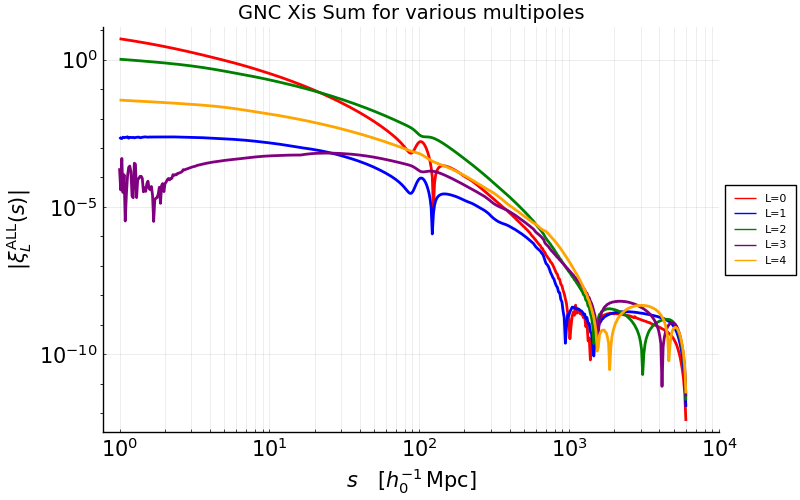

In [23]:
pyplot()

p_xis = plot(
    size=(800, 500), title="GNC Xis Sum for various multipoles", 
    xlabel=L"s \quad [h_0^{-1}\,\mathrm{Mpc}]",
    ylabel=L"|\xi^{\mathrm{ALL}}_{L}(s)|",
    #yticks = 10.0 .^ [i for i in -6:1:6], ylims = (1e2, 1e6),
    xticks = (
        vcat([a*10.0^b for b in 0:3 for a in 1:9], 10.0^4), 
        vcat([a==1 ? L"10^{%$b}" : nothing for b in 0:3 for a in 1:9], L"10^{4}")
    ),
    xaxis=:log, yaxis=:log,
    tickfontsize=15, labelfontsize=15,
    legend=:outerright)

for (i,L) in enumerate(VEC_L)
    plot!(p_xis, 
        ss[vec_sum_xis[i] .≠ 0.0], abs.(vec_sum_xis[i])[vec_sum_xis[i] .≠ 0.0], 
        lw=2, label="L=$L"
    )
end
#savefig(p_xis, DIR*"XIS_withF_noobs"*filenames_appendix*".pdf");
p_xis

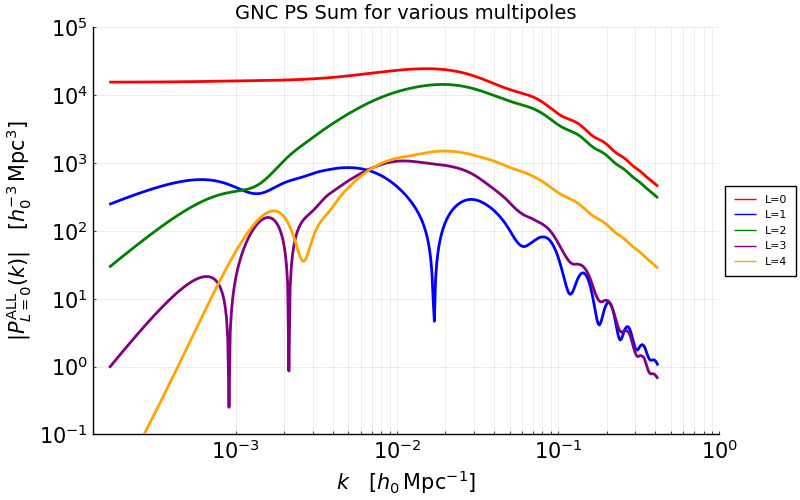

In [24]:
pyplot()

p_ps = plot(
    size=(800, 500),
    yticks = 10.0 .^ [i for i in -6:1:6], ylims = (1e-1, 1e5),
    xticks = (
        vcat([a*10.0^b for b in -3:(-1) for a in 1:9], 10.0^0), 
        vcat([a==1 ? L"10^{%$b}" : nothing for b in -3:(-1) for a in 1:9], L"10^{0}")
    ),
    title="GNC PS Sum for various multipoles", 
    xlabel=L"k \quad [h_0 \,\mathrm{Mpc}^{-1}]",
    ylabel=L"|P^{\mathrm{ALL}}_{L=0}(k)|  \quad [h_0^{-3} \,\mathrm{Mpc}^3] ",
    xaxis=:log, yaxis=:log,
    tickfontsize=15, labelfontsize=15,
    legend=:outerright)

for (i,L) in enumerate(VEC_L)
    try 
        plot!(p_ps, 
            (vec_ks[i])[abs.(vec_sum_pks[i]) .≠ 0.0], abs.(vec_sum_pks[i])[abs.(vec_sum_pks[i]) .≠ 0.0], 
            lw=2, label="L=$L"
        )
    catch e
       nothing 
    end
end

#savefig(p_ps, DIR*"PS_withF_noobs"*filenames_appendix*".pdf");
p_ps

## Comparison PS of GNC sum and Plain-Parallel (PP) Approximation of the Galaxies

### Computations of the PP Galaxies TPCFs and PS 

In [25]:
name_xi_ppg_L0 = DIR*"xi_ppg_L0_withF"*filenames_appendix*".txt";
name_xi_ppg_L2 = DIR*"xi_ppg_L2_withF"*filenames_appendix*".txt";
name_xi_ppg_L4 = DIR*"xi_ppg_L4_withF"*filenames_appendix*".txt";

name_ps_ppg_L0 = DIR*"ps_ppg_L0_withF"*filenames_appendix*".txt";
name_ps_ppg_L2 = DIR*"ps_ppg_L2_withF"*filenames_appendix*".txt";
name_ps_ppg_L4 = DIR*"ps_ppg_L4_withF"*filenames_appendix*".txt";

In [34]:
GaPSE.print_map_ξ_PPGalaxies_multipole(cosmo, name_xi_ppg_L0,
    10 .^ range(0,log10(2*cosmo.s_max),length=500);
    L = 0, use_windows = true, pr = true, enhancer = 1e6,
    atol_quad = 0.0, rtol_quad = 1e-2);
GaPSE.print_PS_multipole(name_xi_ppg_L0, 
    name_ps_ppg_L0; L = 0, ps_kwargs(tf)...);

GaPSE.print_map_ξ_PPGalaxies_multipole(cosmo, name_xi_ppg_L2,
    10 .^ range(0,log10(2*cosmo.s_max),length=500);
    L = 2, use_windows = true, pr = true, enhancer = 1e6,
    atol_quad = 0.0, rtol_quad = 1e-2);
GaPSE.print_PS_multipole(name_xi_ppg_L2, 
    name_ps_ppg_L2; L = 2, ps_kwargs(tf)...);

GaPSE.print_map_ξ_PPGalaxies_multipole(cosmo, name_xi_ppg_L4,
    10 .^ range(0,log10(2*cosmo.s_max),length=500);
    L = 4, use_windows = true, pr = true, enhancer = 1e6,
    atol_quad = 0.0, rtol_quad = 1e-2);
GaPSE.print_PS_multipole(name_xi_ppg_L4, 
    name_ps_ppg_L4; L = 4, ps_kwargs(tf)...);

PP Galaxies, L=0: 100%|█████████████████████████████████| Time: 0:00:13



time needed for map_ξ_PPGalaxies_multipole [in s] = 13.08442 

I'm computing the PS_multipole from the two input vectors.

time needed for this Power Spectrum computation [in s] = 0.0007200241088867188



PP Galaxies, L=2: 100%|█████████████████████████████████| Time: 0:00:08



time needed for map_ξ_PPGalaxies_multipole [in s] = 8.69034 

I'm computing the PS_multipole from the two input vectors.

time needed for this Power Spectrum computation [in s] = 0.0006649494171142578



PP Galaxies, L=4: 100%|█████████████████████████████████| Time: 0:00:57



time needed for map_ξ_PPGalaxies_multipole [in s] = 57.02315 

I'm computing the PS_multipole from the two input vectors.

time needed for this Power Spectrum computation [in s] = 0.0007889270782470703



In [35]:
ss_ppg_L0, xis_ppg_L0 = GaPSE.readxy(name_xi_ppg_L0);
ks_ppg_L0, pks_ppg_L0 = GaPSE.readxy(name_ps_ppg_L0);

ss_ppg_L2, xis_ppg_L2 = GaPSE.readxy(name_xi_ppg_L2);
ks_ppg_L2, pks_ppg_L2 = GaPSE.readxy(name_ps_ppg_L2);

ss_ppg_L4, xis_ppg_L4 = GaPSE.readxy(name_xi_ppg_L4);
ks_ppg_L4, pks_ppg_L4 = GaPSE.readxy(name_ps_ppg_L4);

In [37]:
name_xi_ppg_noF_L0 = DIR*"xi_ppg_L0_noF"*filenames_appendix*".txt";
name_xi_ppg_noF_L2 = DIR*"xi_ppg_L2_noF"*filenames_appendix*".txt";
name_xi_ppg_noF_L4 = DIR*"xi_ppg_L4_noF"*filenames_appendix*".txt";

name_ps_ppg_noF_L0 = DIR*"ps_ppg_L0_noF"*filenames_appendix*".txt";
name_ps_ppg_noF_L2 = DIR*"ps_ppg_L2_noF"*filenames_appendix*".txt";
name_ps_ppg_noF_L4 = DIR*"ps_ppg_L4_noF"*filenames_appendix*".txt";

GaPSE.print_map_ξ_PPGalaxies_multipole(cosmo, name_xi_ppg_noF_L0,
    10 .^ range(0,log10(2*cosmo.s_max),length=500);
    L = 0, use_windows = false, pr = true, enhancer = 1e6,
    atol_quad = 0.0, rtol_quad = 1e-2);
GaPSE.print_PS_multipole(name_xi_ppg_noF_L0, 
    name_ps_ppg_noF_L0; L = 0, ps_kwargs(tf)...);

GaPSE.print_map_ξ_PPGalaxies_multipole(cosmo, name_xi_ppg_noF_L2,
    10 .^ range(0,log10(2*cosmo.s_max),length=500);
    L = 2, use_windows = false, pr = true, enhancer = 1e6,
    atol_quad = 0.0, rtol_quad = 1e-2);
GaPSE.print_PS_multipole(name_xi_ppg_noF_L2, 
    name_ps_ppg_noF_L2; L = 2, ps_kwargs(tf)...);

GaPSE.print_map_ξ_PPGalaxies_multipole(cosmo, name_xi_ppg_noF_L4,
    10 .^ range(0,log10(2*cosmo.s_max),length=500);
    L = 4, use_windows = false, pr = true, enhancer = 1e6,
    atol_quad = 0.0, rtol_quad = 1e-2);
GaPSE.print_PS_multipole(name_xi_ppg_noF_L4, 
    name_ps_ppg_noF_L4; L = 4, ps_kwargs(tf)...);

ss_ppg_noF_L0, xis_ppg_noF_L0 = GaPSE.readxy(name_xi_ppg_noF_L0);
ks_ppg_noF_L0, pks_ppg_noF_L0 = GaPSE.readxy(name_ps_ppg_noF_L0);

ss_ppg_noF_L2, xis_ppg_noF_L2 = GaPSE.readxy(name_xi_ppg_noF_L2);
ks_ppg_noF_L2, pks_ppg_noF_L2 = GaPSE.readxy(name_ps_ppg_noF_L2);

ss_ppg_noF_L4, xis_ppg_noF_L4 = GaPSE.readxy(name_xi_ppg_noF_L4);
ks_ppg_noF_L4, pks_ppg_noF_L4 = GaPSE.readxy(name_ps_ppg_noF_L4);


time needed for map_ξ_PPGalaxies_multipole [in s] = 0.06646 

I'm computing the PS_multipole from the two input vectors.

time needed for this Power Spectrum computation [in s] = 0.0018849372863769531


time needed for map_ξ_PPGalaxies_multipole [in s] = 0.05231 

I'm computing the PS_multipole from the two input vectors.

time needed for this Power Spectrum computation [in s] = 0.0008540153503417969


time needed for map_ξ_PPGalaxies_multipole [in s] = 0.05139 

I'm computing the PS_multipole from the two input vectors.

time needed for this Power Spectrum computation [in s] = 0.0007798671722412109



### Comparison plots

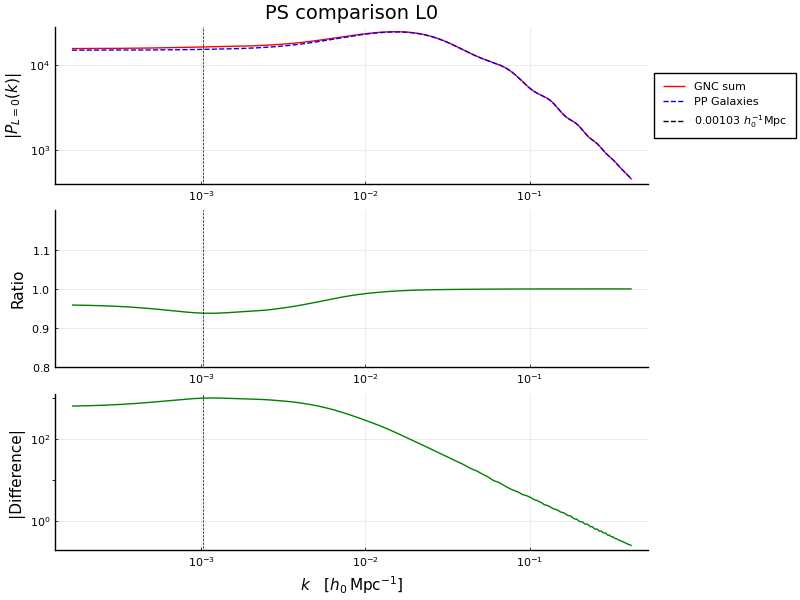

In [51]:
xs_1 = vec_ks[1]
ys_1 = abs.(vec_sum_pks[1]) # L=0

xs_2 = ks_ppg_L0
ys_2 = pks_ppg_L0
spline = Spline1D(xs_2, ys_2)

S_VLIM = 2*π/(2*cosmo.s_max)
S_VLIM_F = @sprintf("%.5f", S_VLIM)

p1 = plot(
    [xs_1[ys_1 .≠ 0], xs_2[ys_2 .≠ 0]], [abs.(ys_1)[ys_1 .≠ 0], abs.(ys_2)[ys_2 .≠ 0]],
    xaxis=:log, yaxis=:log, 
    lc=[:red :blue], #yticks = 10.0 .^ [i for i in 2:5],
    title = "PS comparison L0",
    label=["GNC sum" "PP Galaxies"], ls=[:solid :dash], 
    ylabel = L"|P_{L=0}(k)|",
    legend=:outerright)
vline!(p1, [S_VLIM], label="$S_VLIM_F " * L" h_0^{-1}\mathrm{Mpc}", lc=:black, lw=0.5, ls=:dash)

p2 = plot(xs_1, spline.(xs_1) ./ ys_1, 
    ylabel="Ratio", lc=:green, 
    xaxis=:log,
    ylim=(0.8,1.2), 
    legend=false, 
    )
vline!(p2, [S_VLIM], label="$S_VLIM_F " * L" h_0^{-1}\mathrm{Mpc}", lc=:black, lw=0.5, ls=:dash)

p3 = plot(xs_1, abs.(spline.(xs_1) .- ys_1), 
    ylabel="|Difference|", lc=:green, 
    xaxis=:log, yaxis=:log,
    #ylim=(0.0,2), 
    legend=false, 
    xlabel=L"$k \quad [h_0 \,\mathrm{Mpc}^{-1}]$")
vline!(p3, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

P = plot(p1, p2, p3, size=(800, 600), layout= @layout [ x ; y ; z ] )
#savefig(P, DIR*"PS_L0_GNCsum-PPGalaxies_withF"*filenames_appendix*".pdf")
#display(P)

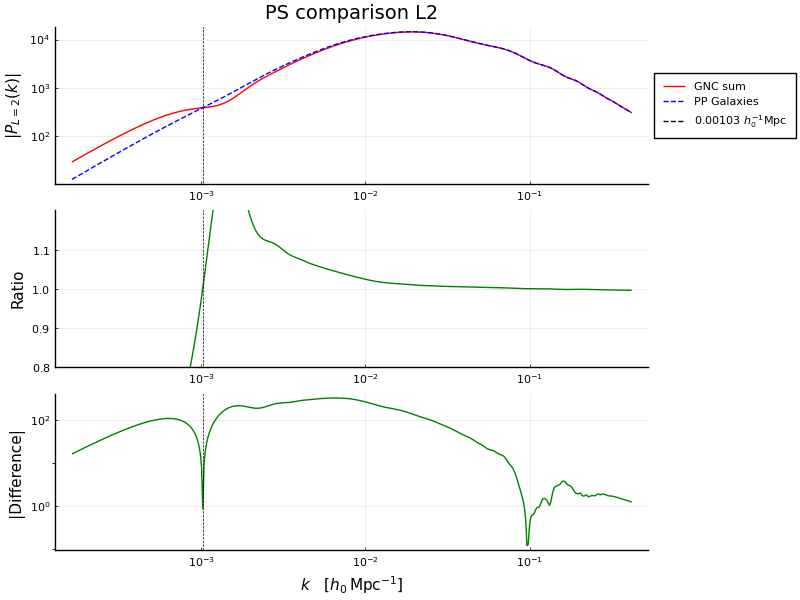

In [50]:
xs_1 = vec_ks[3]
ys_1 = abs.(vec_sum_pks[3]) # L=0

xs_2 = ks_ppg_L2
ys_2 = pks_ppg_L2
spline = Spline1D(xs_2, ys_2)

S_VLIM = 2*π/(2*cosmo.s_max)
S_VLIM_F = @sprintf("%.5f", S_VLIM)

p1 = plot(
    [xs_1[ys_1 .≠ 0], xs_2[ys_2 .≠ 0]], [abs.(ys_1)[ys_1 .≠ 0], abs.(ys_2)[ys_2 .≠ 0]],
    xaxis=:log, yaxis=:log, 
    lc=[:red :blue], #yticks = 10.0 .^ [i for i in 2:5],
    title = "PS comparison L2",
    label=["GNC sum" "PP Galaxies"], ls=[:solid :dash], 
    ylabel = L"|P_{L=2}(k)|",
    legend=:outerright)
vline!(p1, [S_VLIM], label="$S_VLIM_F " * L" h_0^{-1}\mathrm{Mpc}", lc=:black, lw=0.5, ls=:dash)

p2 = plot(xs_1, spline.(xs_1) ./ ys_1, 
    ylabel="Ratio", lc=:green, 
    xaxis=:log,
    ylim=(0.8,1.2), 
    legend=false, 
    )
vline!(p2, [S_VLIM], label="$S_VLIM_F " * L" h_0^{-1}\mathrm{Mpc}", lc=:black, lw=0.5, ls=:dash)

p3 = plot(xs_1, abs.(spline.(xs_1) .- ys_1), 
    ylabel="|Difference|", lc=:green, 
    xaxis=:log, yaxis=:log,
    #ylim=(0.0,2), 
    legend=false, 
    xlabel=L"$k \quad [h_0 \,\mathrm{Mpc}^{-1}]$")
vline!(p3, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

P = plot(p1, p2, p3, size=(800, 600), layout= @layout [ x ; y ; z ] )
#savefig(P, DIR*"PS_L0_GNCsum-PPGalaxies_withF"*filenames_appendix*".pdf")
#display(P)

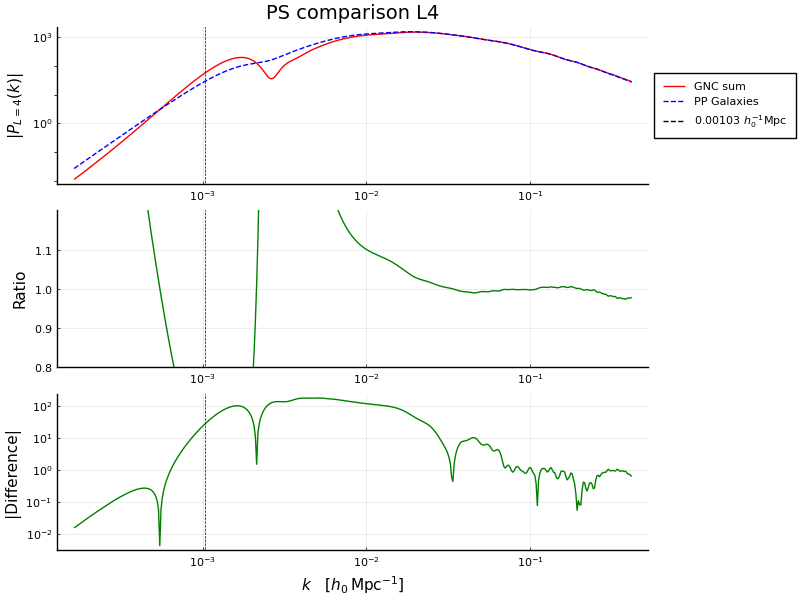

In [52]:
xs_1 = vec_ks[5]
ys_1 = abs.(vec_sum_pks[5]) # L=0

xs_2 = ks_ppg_L4
ys_2 = pks_ppg_L4
spline = Spline1D(xs_2, ys_2)

S_VLIM = 2*π/(2*cosmo.s_max)
S_VLIM_F = @sprintf("%.5f", S_VLIM)

p1 = plot(
    [xs_1[ys_1 .≠ 0], xs_2[ys_2 .≠ 0]], [abs.(ys_1)[ys_1 .≠ 0], abs.(ys_2)[ys_2 .≠ 0]],
    xaxis=:log, yaxis=:log, 
    lc=[:red :blue], #yticks = 10.0 .^ [i for i in 2:5],
    title = "PS comparison L4",
    label=["GNC sum" "PP Galaxies"], ls=[:solid :dash], 
    ylabel = L"|P_{L=4}(k)|",
    legend=:outerright)
vline!(p1, [S_VLIM], label="$S_VLIM_F " * L" h_0^{-1}\mathrm{Mpc}", lc=:black, lw=0.5, ls=:dash)

p2 = plot(xs_1, spline.(xs_1) ./ ys_1, 
    ylabel="Ratio", lc=:green, 
    xaxis=:log, label="PP withF / GNCsum",
    ylim=(0.8,1.2), 
    legend=false, 
    )
vline!(p2, [S_VLIM], label="$S_VLIM_F " * L" h_0^{-1}\mathrm{Mpc}", lc=:black, lw=0.5, ls=:dash)

p3 = plot(xs_1, abs.(spline.(xs_1) .- ys_1), 
    ylabel="|Difference|", lc=:green, 
    xaxis=:log, yaxis=:log,
    #ylim=(0.0,2), 
    legend=false, 
    xlabel=L"$k \quad [h_0 \,\mathrm{Mpc}^{-1}]$")
vline!(p3, [S_VLIM], label="$S_VLIM_F " * L" h_0^{-1}\mathrm{Mpc}", lc=:black, lw=0.5, ls=:dash)

P = plot(p1, p2, p3, size=(800, 600), layout= @layout [ x ; y ; z ] )
#savefig(P, DIR*"PS_L0_GNCsum-PPGalaxies_withF"*filenames_appendix*".pdf")
#display(P)

## END